In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from project_imports import *
import seaborn as sns

In [230]:
def make_feature(feature_name, unique_cards, fn):
    
    if fn is not None:
        print('Calculating feature')
        feature_df = fn
        feature_df.to_parquet(mapper.interim_data_dir/f'{feature_name}.parquet')
        
    print('Loading feature from hard disk')
    return_df = pd.read_parquet(mapper.interim_data_dir/f'{feature_name}.parquet')

    assert return_df.card_id.nunique()==unique_cards    
    
    return return_df


def pivot_column(df, feature_to_pivot, agg_, return_columns, result_as_percent=False):
    
    grouped = groupby_and_agg(df, ['card_id', feature_to_pivot], agg_=agg_)
    
    pivotted = grouped.pivot(index='card_id', columns=feature_to_pivot, values=0).reset_index()
    
    if result_as_percent:
        
        percent_columns = list(pivotted.columns.drop('card_id'))
        
        pivotted['total'] = np.sum(pivotted[percent_columns], axis=1)
        
        for c in percent_columns:
                        
            pivotted[c] = pivotted[c] / pivotted['total']
            
    if return_columns is not None:
        return_df = pivotted[return_columns]
    else:
        return_df = pivotted
    
    return return_df


def plot_hist(df, fig_title, **kwargs):

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(25, 10))

    ax0 = sns.histplot(data=df, x=df.columns[-1], ax=ax0, **kwargs)
    ax1 = sns.histplot(data=df, x=df.columns[-1], ax=ax1, **kwargs)
    
    ax1.set_yscale('log')
    ax1.set_ylabel('Log Count')

    fig.suptitle(fig_title)
    
    return 


########################### i have the makings of a nice little class here - make sure to make this into a class at some point ##########################################

# what city is earch card purchasing in the most?
# i do have some ties in this data set so I'll break the tie by taking the city card spent the most money in

def card_max_over_feature(df, feature_name, agg, final_col_name, tiebreak_agg=None, join_type='inner'):

    # first group and aggregate by card id and the feature I want to take max over
    per_feature = groupby_and_agg(df, ['card_id', feature_name], agg)

    # handle cases where the agg arg is a string. ex. 'size'
    assert type(agg) == str or type(agg) == dict

    if type(agg) == str:
        per_feature = per_feature.rename(columns={0: f'{feature_name}_{agg}'})
        agg_feature_name = f'{feature_name}_{agg}'

    else:
        # right now only allowing one aggregation on one field at a time
        assert len(agg) == 1
        key, value = list(agg.items())[0]
        assert type(value) == list
        agg_feature_name = f'{key}_{value[0]}'


    # now find the max of that feature for the card
    max_feature = groupby_and_agg(per_feature, 'card_id', {agg_feature_name: ['max']})

    # inner join the aggregation and max to come out with only the top choice at that category for a card
    # use inner join if you want only the final result, left join if you want to do some validation
    return_df = pd.merge(per_feature, max_feature, how=join_type, left_on=['card_id', agg_feature_name], right_on=['card_id', f'{agg_feature_name}_max'])
    
    return_df = return_df.rename(columns={feature_name: final_col_name})

    return_df = return_df[['card_id', final_col_name, agg_feature_name]]

    if tiebreak_agg is not None:

        return_df = break_ties(return_df, final_col_name, tiebreak_agg, original_max_feature=feature_name)

    return return_df


def break_ties(df, tiebreak_feature, tiebreak_agg, original_max_feature=None):

    # find duplicate cards
    dup_cards = df[df.duplicated('card_id', keep=False)].card_id.unique()
    print(f'There were {len(dup_cards)} duplicate cards')

    # subset the df where I have ties 
    dups_df = df[df.card_id.isin(dup_cards)]

    # let's make sure i have ties at this point
    if len(dups_df) == 0:
        print('No ties detected. Returning original DatFrame')
        return df

    # join back to historical data so i only have data for tie cities for each card, then break the ties
    dup_keyed_historicals = pd.merge(dups_df, historicals, how='inner', left_on=['card_id', tiebreak_feature], right_on=['card_id', 'city_id'])
    tiebreaker = card_max_over_feature(dup_keyed_historicals, 'city_id', tiebreak_agg, f'{tiebreak_feature}_tiebreaker')

    # calculate how many duplicates i have resolved before return 
    count_dup_cards_remaining = tiebreaker[tiebreaker.duplicated(subset='card_id', keep=False)].card_id.nunique()
    dup_cards_resolved = len(dup_cards) - count_dup_cards_remaining
    print(f'{dup_cards_resolved} cards were resolved through tiebreaker')

    # i want one more check here to make sure that the tiebreaker cities are present in the dups df for every card


    # then i want to replace my duplications with the tiebreakers
    de_duped = pd.merge(dups_df, tiebreaker, how='inner', left_on=['card_id' , tiebreak_feature], right_on=['card_id', f'{tiebreak_feature}_tiebreaker'])

    # need to drop a couple columns from the tiebreaker process before returning
    assert type(tiebreak_agg) == str or type(tiebreak_agg) == dict

    if type(tiebreak_agg) == str:
        tiebreak_agg_feature_name = f'{original_max_feature}_{tiebreak_agg}'

    else:
        # right now only allowing one aggregation on one field at a time
        assert len(tiebreak_agg) == 1
        key, value = list(tiebreak_agg.items())[0]
        assert type(value) == list
        tiebreak_agg_feature_name = f'{key}_{value[0]}'

    de_duped.drop([f'{tiebreak_feature}_tiebreaker', tiebreak_agg_feature_name], axis=1, inplace=True)

    # now i can replace my ties with the tiebreakers
    no_dups_df = df[~df.card_id.isin(dup_cards)]
    return_df = pd.concat([no_dups_df, de_duped], axis=0)

    if count_dup_cards_remaining > 0:

        print(f"Resolving remaining {count_dup_cards_remaining} duplications through random choice")

        # find the remaining duplicates
        remaining_dup_cards = return_df[return_df.duplicated('card_id', keep=False)].card_id.unique()
        remaining_dups_df = return_df[return_df.card_id.isin(remaining_dup_cards)]

        # break the remaining ties
        tiebreaker_random = break_ties_random_choice(remaining_dups_df)

        no_remaining_dups_df = return_df[~return_df.card_id.isin(remaining_dup_cards)]
        return_df = pd.concat([no_remaining_dups_df, tiebreaker_random])

    # make sure that there are no duplicates left before returning
    if df.card_id.nunique() == return_df.card_id.nunique():
        print('All duplicates handled')
    else:
        print('Some duplicates remain... further dedup steps needed')

    return return_df


def break_ties_random_choice(df):

    # find duplicate cards
    dup_cards = df[df.duplicated('card_id', keep=False)].card_id.unique()

    # subset the df where I have ties 
    dups_df = df[df.card_id.isin(dup_cards)]

    # let's make sure i have ties at this point
    if len(dups_df) == 0:
        print('No ties detected. Returning original DatFrame')
        return df

    # select a random record for each card then make df of those selections
    gb = dups_df.groupby(['card_id'])
    blocks = [data.sample(n=1) for _,data in gb]
    tiebreaker_random = pd.concat(blocks)   

    return tiebreaker_random


In [3]:
mapper = DirectoryMapper('elo_merch_cat_reqs')


# Basic Training Set

In [15]:
train = pd.read_csv(mapper.raw_data_dir/'train.csv')
df_multiple_summary(train)

info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   first_active_month  201917 non-null  object 
 1   card_id             201917 non-null  object 
 2   feature_1           201917 non-null  int64  
 3   feature_2           201917 non-null  int64  
 4   feature_3           201917 non-null  int64  
 5   target              201917 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 9.2+ MB
None

unique
first_active_month        75
card_id               201917
feature_1                  5
feature_2                  3
feature_3                  2
target                197110
dtype: int64


,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749
...,...,...,...,...,...,...
201912,2017-09,C_ID_963962de2c,3,2,1,-2.740821
201913,2015-10,C_ID_1314773c0b,3,1,1,0.312917
201914,2017-08,C_ID_7666735b3d,4,3,0,0.093494
201915,2016-07,C_ID_73f5a0efd0,3,2,1,-4.676589


<AxesSubplot:>

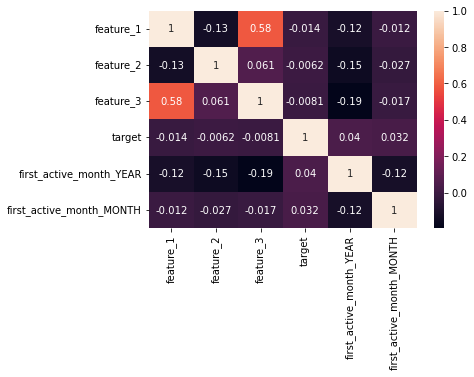

In [16]:
# Let's get those dates broken out into separate columns - no days since always first of month
X_train = handle_date_cols(train, ['first_active_month'], add_date_parts=True)

# Correlation matrix for these basic features
corr = X_train.drop(['card_id'], axis=1).corr()
sns.heatmap(corr, annot=True)

# Historical Purchase Data

In [6]:
historicals = pd.read_csv(mapper.raw_data_dir/'historical_transactions.csv')
df_multiple_summary(historicals)

info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
 #   Column                Dtype  
---  ------                -----  
 0   authorized_flag       object 
 1   card_id               object 
 2   city_id               int64  
 3   category_1            object 
 4   installments          int64  
 5   category_3            object 
 6   merchant_category_id  int64  
 7   merchant_id           object 
 8   month_lag             int64  
 9   purchase_amount       float64
 10  purchase_date         object 
 11  category_2            float64
 12  state_id              int64  
 13  subsector_id          int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 3.0+ GB
None

unique
authorized_flag                2
card_id                   325540
city_id                      308
category_1                     2
installments                  15
category_3                     3
merchant_category_id         327
merchant_id   

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29112356,Y,C_ID_2863d2fa95,-1,Y,1,B,360,M_ID_edd92b6720,-1,-0.632706,2017-01-20 08:52:04,NaN,-1,34
29112357,Y,C_ID_2863d2fa95,-1,Y,1,B,360,M_ID_edd92b6720,0,-0.632706,2017-02-20 04:40:50,NaN,-1,34
29112358,Y,C_ID_5c240d6e3c,3,N,0,A,278,M_ID_9cdcfe8673,0,-0.657740,2017-12-26 18:37:51,1.0,16,37
29112359,Y,C_ID_5c240d6e3c,331,N,0,A,514,M_ID_1a75f94f92,-1,0.770620,2017-11-24 14:18:15,1.0,16,9


In [7]:
historicals.describe()

,city_id,installments,merchant_category_id,month_lag,purchase_amount,category_2,state_id,subsector_id
count,2.911236e+07,2.911236e+07,2.911236e+07,2.911236e+07,2.911236e+07,2.645950e+07,2.911236e+07,2.911236e+07
mean,1.293256e+02,6.484954e-01,4.810130e+02,-4.487294e+00,3.640090e-02,2.194578e+00,1.056679e+01,2.684839e+01
std,1.042563e+02,2.795577e+00,2.493757e+02,3.588800e+00,1.123522e+03,1.531896e+00,6.366927e+00,9.692793e+00
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.300000e+01,-7.469078e-01,1.000000e+00,-1.000000e+00,-1.000000e+00
25%,5.300000e+01,0.000000e+00,3.070000e+02,-7.000000e+00,-7.203559e-01,1.000000e+00,9.000000e+00,1.900000e+01
50%,9.000000e+01,0.000000e+00,4.540000e+02,-4.000000e+00,-6.883495e-01,1.000000e+00,9.000000e+00,2.900000e+01
75%,2.120000e+02,1.000000e+00,7.050000e+02,-2.000000e+00,-6.032543e-01,3.000000e+00,1.600000e+01,3.400000e+01
max,3.470000e+02,9.990000e+02,8.910000e+02,0.000000e+00,6.010604e+06,5.000000e+00,2.400000e+01,4.100000e+01


In [8]:
historicals_unique_cards = historicals.card_id.nunique()
historicals_unique_cards

325540

## Calculated Features

    1. transactions_per_card - pd.DataFrame(historicals.groupby('card_id').size()).reset_index().rename(columns={0:'number_of_purchases'})
    
    2. authorized_transactions - pivot_column(historicals, 'authorized_flag', 'size', return_columns=['card_id', 'Y'], result_as_percent=True))

    3. city with most purchases - card_max_over_feature(historicals, 'city_id', 'size', 'most_purchases_city_id', tiebreak_agg={'purchase_amount':['median']}, join_type='inner')

    4. city where median spending was highest - card_max_over_feature(historicals, 'city_id', {'purchase_amount':['median']}, 'highest_purchases_city_id', tiebreak_agg='size')

Loading feature from hard disk


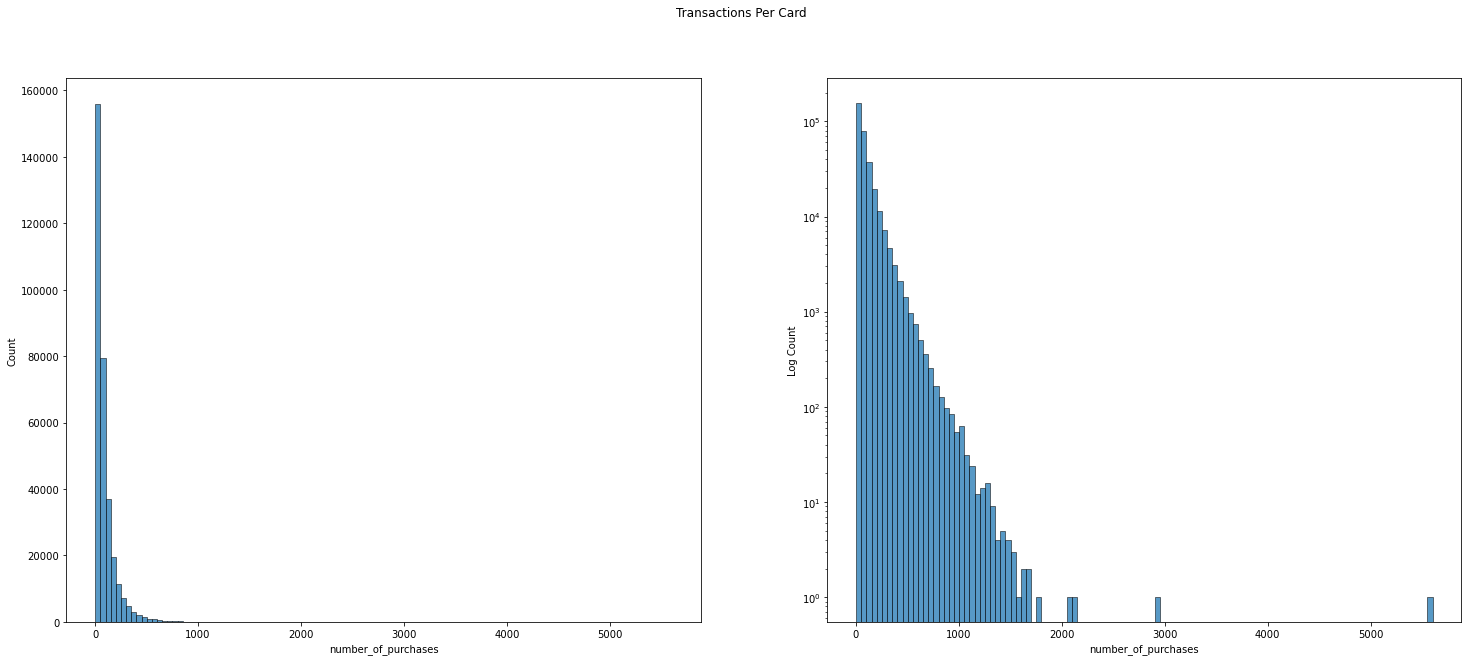

In [9]:
transactions_per_card = make_feature('transactions_per_card', unique_cards=historicals_unique_cards, fn=None)

plot_hist(transactions_per_card, 'Transactions Per Card', binwidth=50)


Loading feature from hard disk


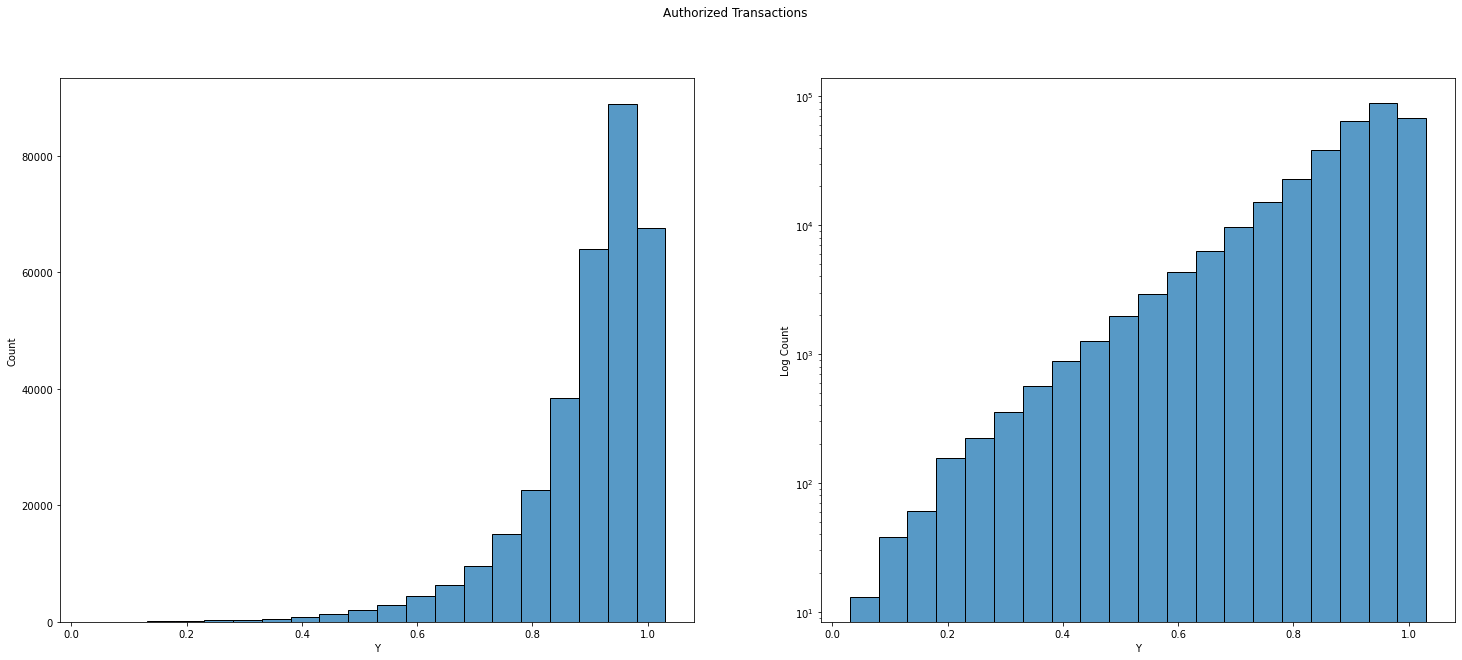

In [10]:
authorized_transactions = make_feature('authorized_transactions', unique_cards=historicals_unique_cards, fn=None)

plot_hist(authorized_transactions, fig_title='Authorized Transactions', binwidth=0.05)

/Users/kevinstoltz/Documents/Projects/Kaggle/elo_merch_cat_reqs/notebooks/project_imports.py:219: UserWarning: No MultiIndex detected. No column collapse wil be performed
  warnings.warn('No MultiIndex detected. No column collapse wil be performed')


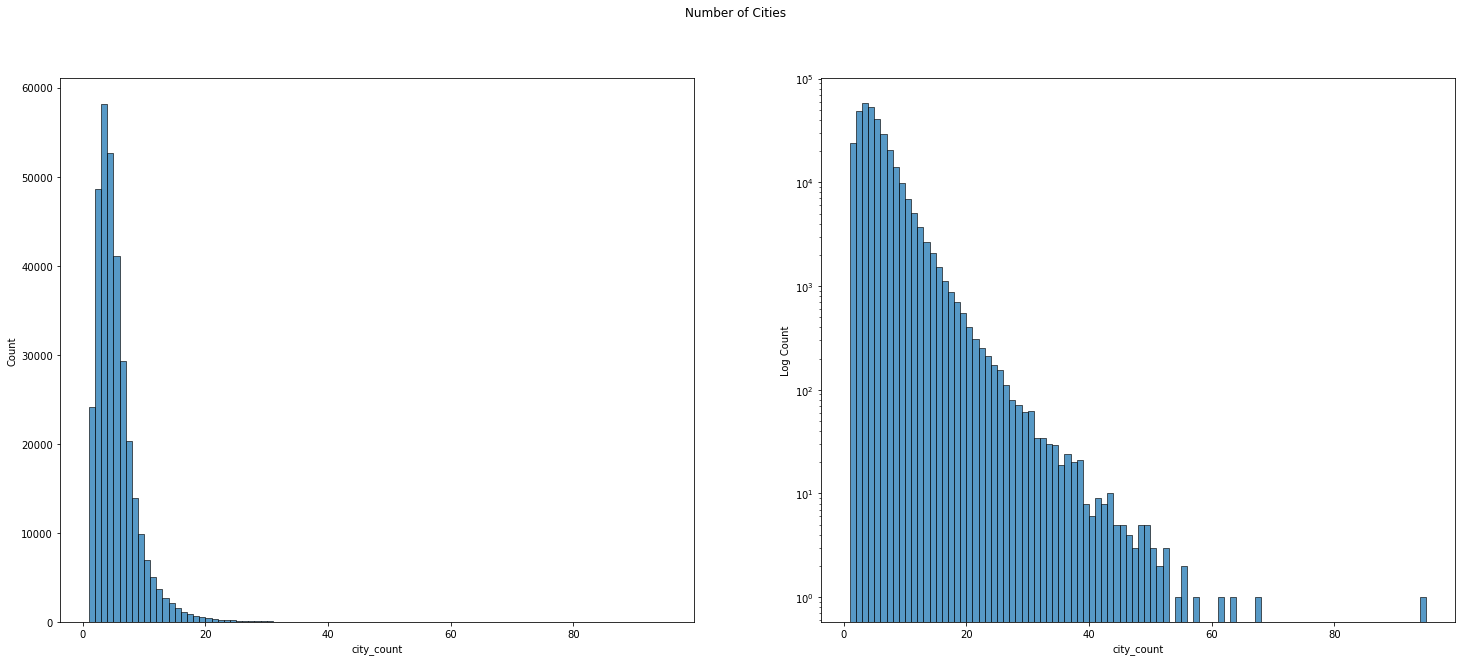

In [11]:
# how many cities are these cards being used in?
cities = groupby_and_agg(historicals, ['card_id'], {'city_id':'nunique'}).rename(columns={'city_id': 'city_count'})

plot_hist(cities, 'Number of Cities', binwidth=1)

In [38]:
# median purchase amount - there are some HUGE outliers in this data set so I want to take mean and median. 
# let's not plot this one because it's hard to do a histogram here - descriptive stats only

# TODO - i need to make this into a feature

purchase_amnt = groupby_and_agg(historicals, ['card_id'], {'purchase_amount':['mean', 'median']})

purchase_amnt.describe()

,purchase_amount_mean,purchase_amount_median
count,325540.000000,325540.000000
mean,1.497803,-0.623883
std,878.426994,0.344122
min,-0.745643,-0.746893
25%,-0.679067,-0.709342
50%,-0.621130,-0.679935
75%,-0.500482,-0.621482
max,500883.004724,84.859130


In [42]:
# just as a side bar here I am really interested to see some of the outliers on purchase amounts
# i might want to remove these at some point in the future but for now i want them to stay in

historicals_purchase_moments = {'mean': historicals.purchase_amount.mean(), 'std': historicals.purchase_amount.std()}
lower = historicals_purchase_moments['mean'] - (1.96 * historicals_purchase_moments['std'])
upper = historicals_purchase_moments['mean'] + (1.96 * historicals_purchase_moments['std'])

purchase_outliers = historicals[~historicals.purchase_amount.between(lower, upper)]
purchase_outliers.sort_values('purchase_amount')

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
3851586,N,C_ID_5b4662d78a,330,N,0,A,705,M_ID_fdf2856c00,-4,2.205758e+03,2017-10-12 15:35:38,3.0,17,33
12107265,N,C_ID_bd3bff9704,150,N,1,B,130,M_ID_26ecc850a6,-8,2.223192e+03,2017-06-03 14:43:34,5.0,5,41
7876481,N,C_ID_41f0080282,19,N,0,A,278,M_ID_d855771cd9,-4,2.224307e+03,2017-10-20 14:20:38,1.0,9,37
23273937,N,C_ID_43b9cc70b8,158,N,0,A,367,M_ID_365f2435ec,0,2.238618e+03,2017-12-24 11:24:37,1.0,15,16
24556103,N,C_ID_bd36256a81,4,N,0,A,560,M_ID_3a26520060,-9,2.238670e+03,2017-05-09 09:30:16,2.0,10,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24263772,N,C_ID_7d394c4bc0,46,N,0,A,108,M_ID_6af581e72e,-7,1.357661e+05,2017-07-22 16:31:19,3.0,19,34
28417440,N,C_ID_c9a8dc2e32,20,N,0,A,309,M_ID_1c93af935a,-9,1.382450e+05,2017-02-25 09:29:43,3.0,19,21
20537106,N,C_ID_bf460be950,87,N,1,B,166,M_ID_be9d815654,-12,1.472606e+05,2017-02-24 12:07:25,3.0,11,29
19745877,N,C_ID_5643cd48de,272,N,0,A,703,M_ID_e0cfe8c8e5,-1,1.652987e+05,2017-10-26 13:37:12,1.0,9,29


In [224]:
# i know i have some ties in here so i will need to break them somehow

most_purchases_city = card_max_over_feature(historicals, 'city_id', 'size', 'most_purchases_city_id', tiebreak_agg={'purchase_amount':['median']}, join_type='inner')

most_purchases_city


/Users/kevinstoltz/Documents/Projects/Kaggle/elo_merch_cat_reqs/notebooks/project_imports.py:219: UserWarning: No MultiIndex detected. No column collapse wil be performed
  warnings.warn('No MultiIndex detected. No column collapse wil be performed')


There were 4318 duplicate cards
4291 cards were resolved through tiebreaker
Resolving remaining 27 duplications through random choice
There were 27 duplicate cards
27 cards were resolved through tiebreaker
All duplicates handled


,card_id,most_purchases_city_id,city_id_size
0,C_ID_00007093c1,244,100
1,C_ID_0001238066,314,40
2,C_ID_0001506ef0,137,63
3,C_ID_0001793786,179,112
4,C_ID_000183fdda,161,123
...,...,...,...
3228,C_ID_bd07c84901,295,16
3678,C_ID_d976f3d079,291,10
3893,C_ID_e62a9e3306,57,7
4040,C_ID_eebe67f7c2,137,9


In [227]:
# TODO - test this workflow to make sure it gives correct output

make_feature(
    'most_purchases_city'
    , unique_cards=325540
    , fn=card_max_over_feature(historicals, 'city_id', 'size', 'most_purchases_city_id', tiebreak_agg={'purchase_amount':['median']}, join_type='inner')
)

/Users/kevinstoltz/Documents/Projects/Kaggle/elo_merch_cat_reqs/notebooks/project_imports.py:219: UserWarning: No MultiIndex detected. No column collapse wil be performed
  warnings.warn('No MultiIndex detected. No column collapse wil be performed')


There were 4318 duplicate cards
4291 cards were resolved through tiebreaker
Resolving remaining 27 duplications through random choice
All duplicates handled
Calculating feature
Loading feature from hard disk


,card_id,most_purchases_city_id,city_id_size
0,C_ID_00007093c1,244,100
1,C_ID_0001238066,314,40
2,C_ID_0001506ef0,137,63
3,C_ID_0001793786,179,112
4,C_ID_000183fdda,161,123
...,...,...,...
3227,C_ID_bd07c84901,69,16
3679,C_ID_d976f3d079,339,10
3894,C_ID_e62a9e3306,149,7
4040,C_ID_eebe67f7c2,137,9


In [225]:
highest_spending_city = card_max_over_feature(historicals, 'city_id', {'purchase_amount':['median']}, 'highest_purchases_city_id', tiebreak_agg='size')

highest_spending_city

There were 2155 duplicate cards


/Users/kevinstoltz/Documents/Projects/Kaggle/elo_merch_cat_reqs/notebooks/project_imports.py:219: UserWarning: No MultiIndex detected. No column collapse wil be performed
  warnings.warn('No MultiIndex detected. No column collapse wil be performed')


1839 cards were resolved through tiebreaker
Resolving remaining 316 duplications through random choice
There were 316 duplicate cards
316 cards were resolved through tiebreaker
All duplicates handled


,card_id,highest_purchases_city_id,purchase_amount_median
0,C_ID_00007093c1,333,-0.392282
1,C_ID_0001238066,143,-0.067709
2,C_ID_0001506ef0,137,-0.700326
3,C_ID_0001793786,322,0.918030
4,C_ID_000183fdda,-1,0.725690
...,...,...,...
2444,C_ID_fc31e02353,-1,-0.701828
2465,C_ID_fe93d89fb0,291,-0.671775
2470,C_ID_fed6abc2c7,25,-0.671775
2474,C_ID_fef51f5271,231,-0.671775


In [228]:
# TODO - test this workflow to make sure it gives correct output

make_feature(
    'highest_spending_city'
    , unique_cards=325540
    , fn=card_max_over_feature(historicals, 'city_id', {'purchase_amount':['median']}, 'highest_purchases_city_id', tiebreak_agg='size')
)

There were 2155 duplicate cards


/Users/kevinstoltz/Documents/Projects/Kaggle/elo_merch_cat_reqs/notebooks/project_imports.py:219: UserWarning: No MultiIndex detected. No column collapse wil be performed
  warnings.warn('No MultiIndex detected. No column collapse wil be performed')


1839 cards were resolved through tiebreaker
Resolving remaining 316 duplications through random choice
All duplicates handled
Calculating feature
Loading feature from hard disk


,card_id,highest_purchases_city_id,purchase_amount_median
0,C_ID_00007093c1,333,-0.392282
1,C_ID_0001238066,143,-0.067709
2,C_ID_0001506ef0,137,-0.700326
3,C_ID_0001793786,322,0.918030
4,C_ID_000183fdda,-1,0.725690
...,...,...,...
2444,C_ID_fc31e02353,-1,-0.701828
2464,C_ID_fe93d89fb0,69,-0.671775
2471,C_ID_fed6abc2c7,107,-0.671775
2474,C_ID_fef51f5271,231,-0.671775


In [ ]:
# TODO - how frequently are the city with most purchases and city with highest median purchase the same city?



In [241]:
# how many options are there for category_1?
print(f'The unique values for column category_1 are {historicals.category_1.unique()}')

# given the above, i'll want to summarize this similar to the way i did for authorized purchses
category_1_yes_freq = pivot_column(historicals, 'category_1', 'size', return_columns=['card_id', 'Y'], result_as_percent=True).fillna(0.0)

# i'll need to deal with the NaN values here - since NaN should mean no 'Y' at all (see example below) i'll fill with 0.0
print(historicals[historicals.card_id=='C_ID_0001506ef0']['category_1'].unique())

category_1_yes_freq

The unique values for column category_1 are ['N' 'Y']


/Users/kevinstoltz/Documents/Projects/Kaggle/elo_merch_cat_reqs/notebooks/project_imports.py:219: UserWarning: No MultiIndex detected. No column collapse wil be performed
  warnings.warn('No MultiIndex detected. No column collapse wil be performed')


['N']


category_1,card_id,Y
0,C_ID_00007093c1,0.187919
1,C_ID_0001238066,0.016260
2,C_ID_0001506ef0,0.000000
3,C_ID_0001793786,0.009259
4,C_ID_000183fdda,0.027778
...,...,...
325535,C_ID_ffff1d9928,0.166667
325536,C_ID_ffff579d3a,0.000000
325537,C_ID_ffff756266,0.125000
325538,C_ID_ffff828181,0.057895


In [234]:
# how many options are there for installments?
print(historicals.installments.unique())

# based on the above, and the info in data dict, i should just be able to take the median of this feature for each card
median_installments = groupby_and_agg(historicals, ['card_id'], {'installments':'median'})
median_installments

# TODO - do i have any NaN values here?

[  0   1   5   3   4   2  -1  10   6  12   8   7   9  11 999]


/Users/kevinstoltz/Documents/Projects/Kaggle/elo_merch_cat_reqs/notebooks/project_imports.py:219: UserWarning: No MultiIndex detected. No column collapse wil be performed
  warnings.warn('No MultiIndex detected. No column collapse wil be performed')


,card_id,installments
0,C_ID_00007093c1,1.0
1,C_ID_0001238066,1.0
2,C_ID_0001506ef0,0.0
3,C_ID_0001793786,0.0
4,C_ID_000183fdda,1.0
...,...,...
325535,C_ID_ffff1d9928,1.0
325536,C_ID_ffff579d3a,0.0
325537,C_ID_ffff756266,2.5
325538,C_ID_ffff828181,1.0


In [235]:
make_feature('median_installments', unique_cards=325540, fn=groupby_and_agg(historicals, ['card_id'], {'installments':'median'}))

/Users/kevinstoltz/Documents/Projects/Kaggle/elo_merch_cat_reqs/notebooks/project_imports.py:219: UserWarning: No MultiIndex detected. No column collapse wil be performed
  warnings.warn('No MultiIndex detected. No column collapse wil be performed')


Calculating feature
Loading feature from hard disk


,card_id,installments
0,C_ID_00007093c1,1.0
1,C_ID_0001238066,1.0
2,C_ID_0001506ef0,0.0
3,C_ID_0001793786,0.0
4,C_ID_000183fdda,1.0
...,...,...
325535,C_ID_ffff1d9928,1.0
325536,C_ID_ffff579d3a,0.0
325537,C_ID_ffff756266,2.5
325538,C_ID_ffff828181,1.0


In [236]:
# how many options are there for category_3?
print(historicals.category_3.unique())

# TODO -  i think i just want to count how many purchases you see in each category (probably expressed as a percent)


['A' 'B' 'C' nan]


# Merchant Data

In [81]:
merchants = pd.read_csv(mapper.raw_data_dir/'merchants.csv')
df_multiple_summary(merchants)

info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   merchant_id                  334696 non-null  object 
 1   merchant_group_id            334696 non-null  int64  
 2   merchant_category_id         334696 non-null  int64  
 3   subsector_id                 334696 non-null  int64  
 4   numerical_1                  334696 non-null  float64
 5   numerical_2                  334696 non-null  float64
 6   category_1                   334696 non-null  object 
 7   most_recent_sales_range      334696 non-null  object 
 8   most_recent_purchases_range  334696 non-null  object 
 9   avg_sales_lag3               334683 non-null  float64
 10  avg_purchases_lag3           334696 non-null  float64
 11  active_months_lag3           334696 non-null  int64  
 12  avg_sales_lag6               334683 non-null  float64

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334691,M_ID_1f4773aa76,1145,705,33,3.174788,-0.047556,N,A,A,1.00,...,0.99,1.019505,6,1.00,1.024796,12,Y,69,9,1.0
334692,M_ID_725a60d404,35,544,29,-0.057471,-0.057471,Y,A,A,0.89,...,0.78,0.813473,6,0.59,0.606765,12,Y,-1,-1,NaN
334693,M_ID_f2045dd267,35,561,7,-0.057471,-0.057471,N,A,A,0.96,...,0.90,0.924769,6,0.74,0.750763,8,Y,160,21,5.0
334694,M_ID_9139332ccc,35,511,7,-0.057471,-0.057471,Y,A,A,0.94,...,0.82,0.783000,6,0.65,0.584000,12,Y,-1,-1,NaN
